# Paper Images

In [275]:
import os
import re
import csv
import sys
import json
import string
import xml.etree.ElementTree as ET
import nltk
nltk.download('words')
from nltk import sent_tokenize
from nltk.corpus import words
from IPython.display import Image
import random
import numpy as np
from termcolor import colored

from IPython.display import HTML as html_print
from IPython.display import Markdown

import cv2
import pandas as pd

import nltk
from nltk import agreement
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from collections import Counter
from scipy.stats import pearsonr
from sklearn.metrics import cohen_kappa_score

from utils import label_samples

from matplotlib import pyplot as plt
%pylab inline
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("ticks")

SPELLCHECKER_WORDS = set(words.words())
DEBUG = False

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package words to
[nltk_data]     /nas/home/telinwu/nltk_data...
[nltk_data]   Package words is already up-to-date!
/nas/home/telinwu/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generals

In [568]:
# qualtric ids
def get_qualt_ids(start_block=1, end_block=24):
    print ("Version: {} instances".format(end_block*30))
    print ('-'*50)
    start_block += 1
    end_block += 2
    start_block = max(2, start_block)
    end_block = min(26, end_block)
    qualt_ids = []
    for block in range(start_block, end_block):
        for ques_idx in range(1, 31):
            qualt_id = "{}_Q{}".format(ques_idx, block)
            qualt_ids.append(qualt_id)
    return qualt_ids

In [571]:
from macros import *

DICT_STRS = {
    "overall": "1. choice",
    "conf": "2. confidence",
    "others": "3. others agreement",
    "com": "4. if common sense",
    "mcq_com": "4. if common sense",
    "edu": "5. education level",
    "clearness": "6. clearness",
    "cat": "7. category",
}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Processed Dicts (JSON)

In [15]:
mcq_dict_f = "../outputs/piqa_qualt_sorted_dict.json"
bin_dict_f = "../outputs/binpiqa_qualt_sorted_dict.json"
mcq_qualt_dict = json.load(open(mcq_dict_f, "r"))
bin_qualt_dict = json.load(open(bin_dict_f, "r"))
qualt_dicts = (mcq_qualt_dict, bin_qualt_dict)

## Pie Charts

In [237]:
# functions
def draw_pie_charts_for_cat_data(qualt_dicts, mode="edu", start_block=1, end_block=24, figsize=(8,8), save_str=None):
    assert mode in ["edu", "cat", "clearness"]
    mcq_qualt_dict, bin_qualt_dict = qualt_dicts
    qualt_ids = get_qualt_ids(start_block=start_block, end_block=end_block)
    
    curr_cat_name = CAT_NAMES[mode]
    qualt_type = DICT_STRS[mode]
    curr_id_dict = CAT_ID_DICTS[mode]
    print ("{}: {}".format(curr_cat_name, qualt_type))
    
    res = []
    
    for qualt_id in qualt_ids:
        mcq_annots = mcq_qualt_dict[qualt_id]["annotations"]
        bin_annots = bin_qualt_dict[qualt_id]["annotations"]
        mcq_cat = mcq_annots[qualt_type]
        bin_cat = bin_annots[qualt_type]
        
        # current logic, have it as long as >= 2 agreed
        if mode in ["edu", "clearness"]:
            joint_cat = mcq_cat + bin_cat
        elif mode in ["cat"]:
            joint_cat = []
            for each in mcq_cat:
                joint_cat += each
            for each in bin_cat:
                joint_cat += each            
        else:
            raise ValueError("No such categorical data: {}".format(mode))
        joint_counter = Counter(joint_cat)
        for ele, cnt in joint_counter.items():
            if cnt > 2:
                res.append(ele)
                
    res_counter = Counter(res)
    labels = []
    sizes = []
    for id_ in sorted(curr_id_dict):
        id_str = curr_id_dict[id_]
        if id_ in res_counter:
            id_cnt = res_counter[id_]
            labels.append(id_str)
            sizes.append(id_cnt)
        else:
            id_cnt = 0
        print ("{}: {}".format(id_str, id_cnt))

        
    # Pie chart
    #colors
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', 'violet', 'lightgray']
    
    #explsion
    explode = [0.02] * len(labels)
    
    fig1, ax1 = plt.subplots(figsize=figsize)
    wedges, texts, autotexts = ax1.pie(sizes, colors = colors,
                                       # labels=labels,
                                       autopct='%1.1f%%',
                                       startangle=90, pctdistance=0.75,
                                       wedgeprops=dict(width=0.5),
                                       shadow=False,
                                       explode=explode)
    
    
    """
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax1.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
    """
    
    ax1.legend(wedges, labels,
               title=curr_cat_name,
               loc="center left",
               fontsize=14,
               bbox_to_anchor=(0.9, 0, 0.3, 0.5))
        
    plt.setp(autotexts, **{'weight':'bold', 'fontsize':14})
    
    #draw circle
    centre_circle = plt.Circle((0,0), 0.50, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')
    # ax1.set_title(curr_cat_name, fontsize=18)
    plt.tight_layout()
    plt.show()
    
    if save_str is not None:
        fig1.savefig(save_str, bbox_inches='tight')
            
    return None

### Educational Levels

Educational Levels: 5. education level
Most 10 year olds: 225
Not most 10 year olds: 329
Only domain experts: 112
No one: 0
Not sure: 35


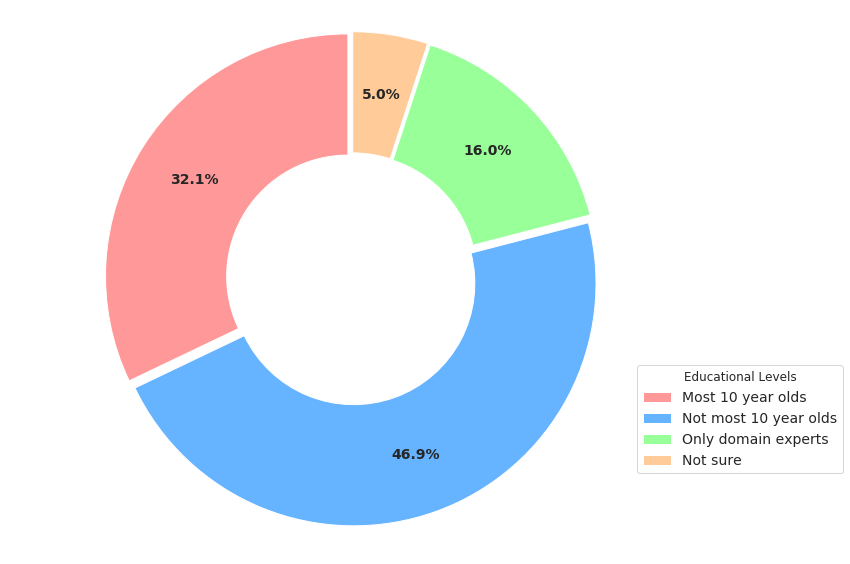

In [238]:
save_str = "imgs/edu_pie_charts.pdf"
draw_pie_charts_for_cat_data(qualt_dicts, mode="edu", end_block=24, figsize=(12,8), save_str=save_str)

### Categories

Physical Common Sense Categories: 7. category
Typical Functions: 256
Affordances: 175
Spatial Relationships: 45
Definitional Attributes: 161
Everyday Knowledge: 270
None of the above: 174


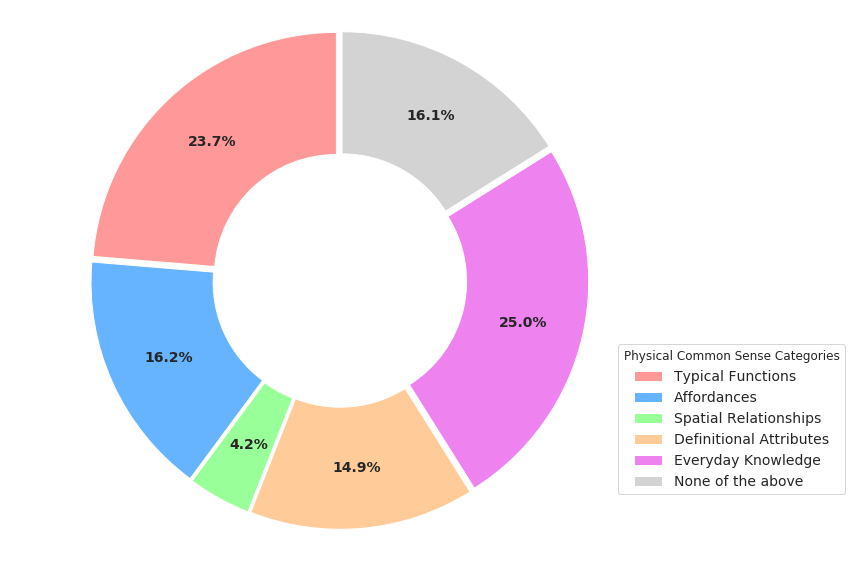

In [239]:
save_str = "imgs/cat_pie_charts.pdf"
draw_pie_charts_for_cat_data(qualt_dicts, mode="cat", end_block=24, figsize=(12,8), save_str=save_str)

## Column Charts

In [563]:
# functions
def draw_column_charts_for_cond_perfs(qualt_dicts, mode="com", start_block=1, end_block=24,
                                      models_to_plot_and_str_mappings=None,
                                      bar_width=0.25, figsize=(8,8), save_str=None):
    assert mode in ["edu", "cat", "com", "clearness", "overall",
                    "mcq_com", "mcq_cat"]
    mcq_qualt_dict, bin_qualt_dict = qualt_dicts
    qualt_ids = get_qualt_ids(start_block=start_block, end_block=end_block)
    
    # get number of annotators
    mcq_models = []
    bin_models = []
    num_annotators_per_question = 0

    annots = mcq_qualt_dict[qualt_ids[0]]["annotations"]["1. choice"]
    num_annots = len(annots)
    num_annotators_per_question = max(num_annotators_per_question, num_annots)
    num_iaas = num_annotators_per_question * 2
    
    mcq_models += list(mcq_qualt_dict[qualt_ids[0]]["model_preds"].keys())
    bin_models += list(bin_qualt_dict[qualt_ids[0]]["model_preds"].keys())
    
    curr_cat_name = CAT_NAMES[mode]
    qualt_type = DICT_STRS[mode]
    curr_id_dict = CAT_ID_DICTS[mode]
    print ("{}: {}".format(curr_cat_name, qualt_type))
    
    all_models = mcq_models + bin_models + ["MCQ-Humans", "BIN-Humans"]
    res = {k: {m: [] for m in all_models} for k in curr_id_dict}
    
    for qualt_id in qualt_ids:
        mcq_annots = mcq_qualt_dict[qualt_id]["annotations"]
        bin_annots = bin_qualt_dict[qualt_id]["annotations"]
        mcq_gt = mcq_qualt_dict[qualt_id]["gt_label"]
        bin_gt = bin_qualt_dict[qualt_id]["gt_label"]
        mcq_cat = mcq_annots[qualt_type]
        bin_cat = bin_annots[qualt_type]
        
        mcq_human_choices = mcq_annots["1. choice"]
        bin_human_choices = bin_annots["1. choice"]
        mcq_human_choices_counter = Counter(mcq_human_choices)
        bin_human_choices_counter = Counter(bin_human_choices)
        mcq_human_choice, mcq_human_choice_cnt = mcq_human_choices_counter.most_common(1)[0]
        bin_human_choice, bin_human_choice_cnt = bin_human_choices_counter.most_common(1)[0]
        assert mcq_human_choice_cnt > num_annotators_per_question // 2 and \
            bin_human_choice_cnt > num_annotators_per_question // 2
        
        # overall performances
        if mode == "overall":
            curr_res_keys = [0]
            
        # current logic, have it as long as >= 2 agreed
        elif mode in ["edu", "clearness", "cat"]:
            if mode in ["edu", "clearness"]:
                joint_cat = mcq_cat + bin_cat
            elif mode in ["cat"]:
                joint_cat = []
                for each in mcq_cat:
                    joint_cat += each
                for each in bin_cat:
                    joint_cat += each            
            else:
                raise ValueError("No such categorical data: {}".format(mode))
            
            joint_counter = Counter(joint_cat)
            curr_res_keys = []
            for ele, cnt in joint_counter.items():
                if cnt > 2:
                    if mode == "cat" and ele >= 5:
                        continue
                    curr_res_keys.append(ele)
                    
        # common sense
        elif "com" in mode:
            if mode == "mcq_com":
                joint_cat = mcq_cat
            else:
                joint_cat = mcq_cat + bin_cat
            joint_counter = Counter(joint_cat)
            joint_if_cs, joint_if_cs_cnt = joint_counter.most_common(1)[0]
            curr_if_cs = None
            if joint_if_cs_cnt > len(joint_cat) // 2:
                if joint_if_cs == 1:
                    curr_if_cs = 1
                else:
                    curr_if_cs = -1
            elif joint_if_cs_cnt == len(joint_cat) // 2:
                curr_if_cs = 0
            else:
                raise
            curr_res_keys = [curr_if_cs]

        # record model performances
        for curr_res_key in curr_res_keys:
            for model in mcq_models:
                if mcq_qualt_dict[qualt_id]["model_preds"][model] == mcq_gt:
                    res[curr_res_key][model].append(1)
                else:
                    res[curr_res_key][model].append(0)
            for model in bin_models:
                if bin_qualt_dict[qualt_id]["model_preds"][model] == bin_gt:
                    res[curr_res_key][model].append(1)
                else:
                    res[curr_res_key][model].append(0)
            if mcq_human_choice == mcq_gt:
                res[curr_res_key]["MCQ-Humans"].append(1)
            else:
                res[curr_res_key]["MCQ-Humans"].append(0)
            if bin_human_choice == bin_gt:
                res[curr_res_key]["BIN-Humans"].append(1)
            else:
                res[curr_res_key]["BIN-Humans"].append(0)
    
    print ('-'*50)
    groups = []
    bars = []
    labels = []
    res_keys = list(res.keys())
    
    if models_to_plot_and_str_mappings is None:
        plot_models = all_models
    else:
        plot_models = list(models_to_plot_and_str_mappings.keys())
    
    for key in res_keys:
        cat_str = curr_id_dict[key]
        print (cat_str)
        groups.append(cat_str)
        bars_tmp = []
        for model in plot_models:
            res_l = np.asarray(res[key][model])
            res_l_acc = np.mean(res_l) * 100.0
            print ("{}: {:.4f}%".format(model, res_l_acc))
            bars_tmp.append(round(res_l_acc, 2))
            if model not in labels:
                if models_to_plot_and_str_mappings is None:
                    labels.append(model)
                else:
                    labels.append(models_to_plot_and_str_mappings[model])
        bars.append(bars_tmp)
        print ('-'*50)
        
    colors = ["lightgreen", "lightcoral", "lightblue", "lightyellow", "lightgrey"]
    
    fig = plot_grouped_bars(bars, labels, groups, colors, 
                            title_str=curr_cat_name, fig_size=figsize, bar_width=bar_width)
    
    if save_str is not None:
        fig.savefig(save_str, bbox_inches='tight')
    
    return fig


def plot_grouped_bars(bars, labels, groups, colors, title_str, save_imgs_dir=None, fig_size=10, bar_width=0.25):
    # set width of bar
    barWidth = bar_width
    
    # Set position of bar on X axis
    rs = []
    rs.append(np.arange(len(bars[0])))
    for i in range(1, len(groups)):
        rs.append([x + barWidth for x in rs[-1]])

    if type(fig_size) == int:
        fig = plt.figure(figsize=(fig_size, fig_size))
    else:
        fig = plt.figure(figsize=fig_size)
     
    # Make the plot
    print (groups)
    for i in range(len(groups)):
        rects = plt.bar(rs[i], bars[i], color=colors[i], width=barWidth, edgecolor='black', label=groups[i])
        for rect in rects:
            height = rect.get_height()
            plt.annotate('{}'.format(height),
                         xy=(rect.get_x() + rect.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')
     
    # Add xticks on the middle of the group bars
    # plt.set_yscale('log') (len(groups)-1)/
    plt.xticks([r + barWidth*len(groups)/2-bar_width/2 for r in range(len(bars[0]))], labels)
    plt.title(title_str, fontsize=18)
    plt.xticks(rotation=0, fontsize=18) 
    plt.yticks(fontsize=18)
    plt.ylim(0, 110)
    
    # Create legend & Show graphic
    plt.legend(fontsize=14, loc='upper center', shadow=True, ncol=len(groups))

    save_imgs_str = "p_meth_label_dist.pdf"
    if save_imgs_dir is not None:
        if not os.path.exists(save_imgs_dir):
            os.makedirs(save_imgs_dir)
        print ("Saving fig {} under dir {}".format(save_imgs_str, save_imgs_dir))
        fig.savefig(os.path.join(save_imgs_dir, save_imgs_str), bbox_inches='tight')
        plt.close(fig)
    return fig

In [557]:
# adding model performances
model_perf_root = "../../ai2_light_telin/outputs"

mcq_model_lsts = [
    os.path.join(model_perf_root, "physicaliqa_ablated2/large_roberta_bz4_accu2"),
    os.path.join(model_perf_root, "physicaliqa_ablated2/lm_finetuned_piqa_existed_cn_iter20k_bz3_accu1"),
    os.path.join(model_perf_root, "physicaliqa_ablated2/lm_finetuned_cn100k_iter60k_bz3_accu1"),
    os.path.join(model_perf_root, "physicaliqa_ablated/lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1"),
    os.path.join(model_perf_root, "physicaliqa/lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1"),
]

bin_model_lsts = [
    os.path.join(model_perf_root, "physicalbinqa/param_sweep_binqa_5050/bz4_accu1_v2_contd"),
]

In [558]:
class Args(object):
    def __init__(self):
        self.mcq_model_preds = mcq_model_lsts
        self.bin_model_preds = bin_model_lsts
        self.mcq_samples_csv = "../files/piqa_survey_sampels_all.csv"
        self.bin_samples_csv = "../files/binpiqa_survey_sampels_all.csv"
        self.mcq_data_jsonl = "../files/dev.jsonl"
        self.mcq_data_lst = "../files/dev-labels.lst"
        self.bin_data_jsonl = "../files/bin-dev.jsonl"
        self.bin_data_lst = "../files/bin-dev-labels.lst"
        self.num_total_blocks = 24
        self.num_questions_each = 30
        
args = Args()
args.data_lst = args.mcq_data_lst

args.task = "physicaliqa"
args.data_jsonl = args.mcq_data_jsonl
args.data_lst = args.mcq_data_lst
args.samples_csv = args.mcq_samples_csv
mcq_qualt_sorted_dict, qualt_id_ai2_id_mapping, ai2_id_qualt_id_mapping = label_samples(args)

args.task = "physicalbinqa"
args.data_jsonl = args.bin_data_jsonl
args.data_lst = args.bin_data_lst
args.samples_csv = args.bin_samples_csv
bin_qualt_sorted_dict, _, _ = label_samples(args)

for qualt_id  in mcq_qualt_sorted_dict:
    if qualt_id not in mcq_qualt_dict:
        continue
    if qualt_id not in bin_qualt_dict:
        continue
    mcq_qualt_dict[qualt_id]["model_preds"] = mcq_qualt_sorted_dict[qualt_id]["model_preds"]
    bin_qualt_dict[qualt_id]["model_preds"] = bin_qualt_sorted_dict[qualt_id]["model_preds"]
    
qualt_dicts = (mcq_qualt_dict, bin_qualt_dict)

[INFO] Num Each Block:   30
[INFO] Num Total Blocks: 24
[INFO] Num Each Block:   30
[INFO] Num Total Blocks: 24


### Overall

Version: 600 instances
--------------------------------------------------
Overall Performances: 1. choice
--------------------------------------------------
Performance
MCQ-Humans: 95.0000%
large_roberta_bz4_accu2: 80.3333%
BIN-Humans: 80.0000%
bz4_accu1_v2_contd: 67.8333%
--------------------------------------------------
['Performance']


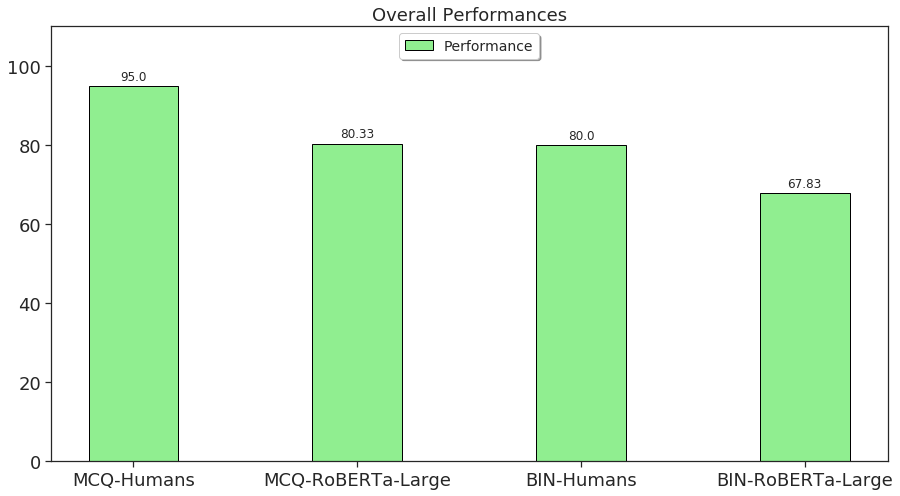

In [494]:
models_to_plot_and_str_mappings = {
    "MCQ-Humans": "MCQ-Humans",
    "large_roberta_bz4_accu2": "MCQ-RoBERTa-Large",
    "BIN-Humans": "BIN-Humans",
    "bz4_accu1_v2_contd": "BIN-RoBERTa-Large",
}
save_str = "imgs/overall_bars_humans_models.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="overall", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        bar_width=0.4, figsize=(15,8), save_str=save_str)

### If Common Sense

Version: 600 instances
--------------------------------------------------
If Common Sense: 4. if common sense
--------------------------------------------------
Common Sense
MCQ-Humans: 97.5000%
large_roberta_bz4_accu2: 83.0000%
BIN-Humans: 84.7500%
bz4_accu1_v2_contd: 68.2500%
--------------------------------------------------
Not Common Sense
MCQ-Humans: 88.2812%
large_roberta_bz4_accu2: 77.3438%
BIN-Humans: 70.3125%
bz4_accu1_v2_contd: 65.6250%
--------------------------------------------------
Neutral
MCQ-Humans: 93.0556%
large_roberta_bz4_accu2: 70.8333%
BIN-Humans: 70.8333%
bz4_accu1_v2_contd: 69.4444%
--------------------------------------------------
['Common Sense', 'Not Common Sense', 'Neutral']


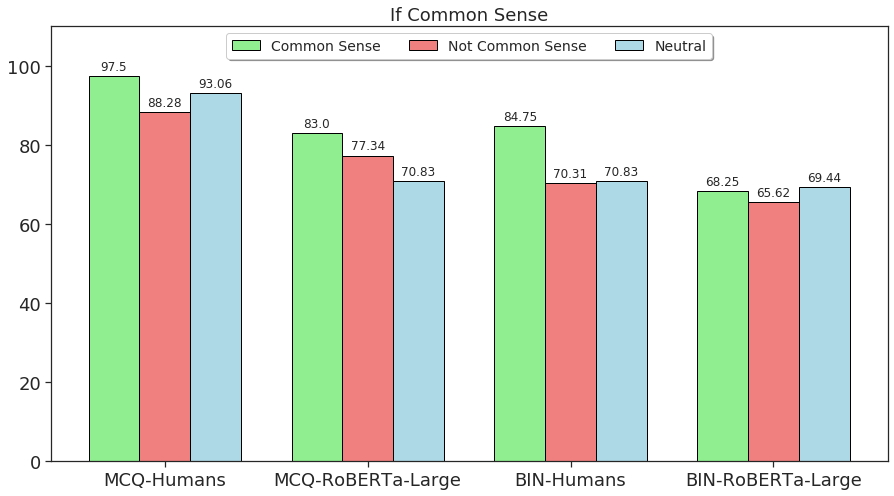

In [512]:
models_to_plot_and_str_mappings = {
    "MCQ-Humans": "MCQ-Humans",
    "large_roberta_bz4_accu2": "MCQ-RoBERTa-Large",
    "BIN-Humans": "BIN-Humans",
    "bz4_accu1_v2_contd": "BIN-RoBERTa-Large",
}
save_str = "imgs/grouped_bars_humans_models_if_cs.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="com", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        bar_width=0.25, figsize=(15,8), save_str=save_str)

Version: 600 instances
--------------------------------------------------
If Common Sense: 4. if common sense
--------------------------------------------------
Common Sense
large_roberta_bz4_accu2: 83.0000%
lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1: 81.0000%
lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1: 78.2500%
--------------------------------------------------
Not Common Sense
large_roberta_bz4_accu2: 77.3438%
lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1: 83.5938%
lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1: 74.2188%
--------------------------------------------------
Neutral
large_roberta_bz4_accu2: 70.8333%
lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1: 73.6111%
lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1: 81.9444%
--------------------------------------------------
['Common Sense', 'Not Common Sense', 'Neutral']


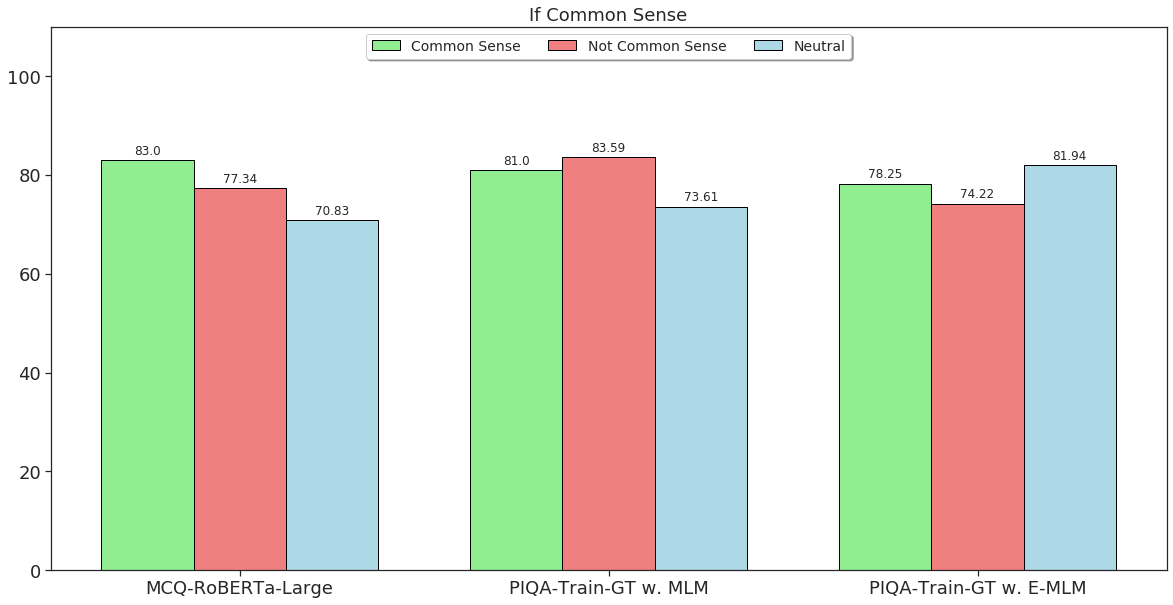

In [574]:
models_to_plot_and_str_mappings = {
    "large_roberta_bz4_accu2": "MCQ-RoBERTa-Large",
    # "lm_finetuned_cn100k_iter60k_bz3_accu1": "CN100k w. MLM",
    "lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1": "PIQA-Train-GT w. MLM",
    "lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1": "PIQA-Train-GT w. E-MLM",
    # "lm_finetuned_piqa_existed_cn_iter20k_bz3_accu1": "PIQA-Train-GT w. C-MLM",
}
save_str = "imgs/grouped_bars_more_models_if_cs.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="com", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        bar_width=0.25, figsize=(20,10), save_str=save_str)

### Categories

Version: 600 instances
--------------------------------------------------
Physical Common Sense Categories: 7. category
--------------------------------------------------
Typical Functions
MCQ-Humans: 98.6667%
large_roberta_bz4_accu2: 84.0000%
BIN-Humans: 82.2222%
bz4_accu1_v2_contd: 69.7778%
--------------------------------------------------
Affordances
MCQ-Humans: 92.2535%
large_roberta_bz4_accu2: 75.3521%
BIN-Humans: 72.5352%
bz4_accu1_v2_contd: 64.7887%
--------------------------------------------------
Spatial Relationships
MCQ-Humans: 100.0000%
large_roberta_bz4_accu2: 82.0513%
BIN-Humans: 87.1795%
bz4_accu1_v2_contd: 71.7949%
--------------------------------------------------
Definitional Attributes
MCQ-Humans: 94.8529%
large_roberta_bz4_accu2: 81.6176%
BIN-Humans: 79.4118%
bz4_accu1_v2_contd: 68.3824%
--------------------------------------------------
Everyday Knowledge
MCQ-Humans: 98.3333%
large_roberta_bz4_accu2: 80.4167%
BIN-Humans: 85.4167%
bz4_accu1_v2_contd: 70.0000%
----

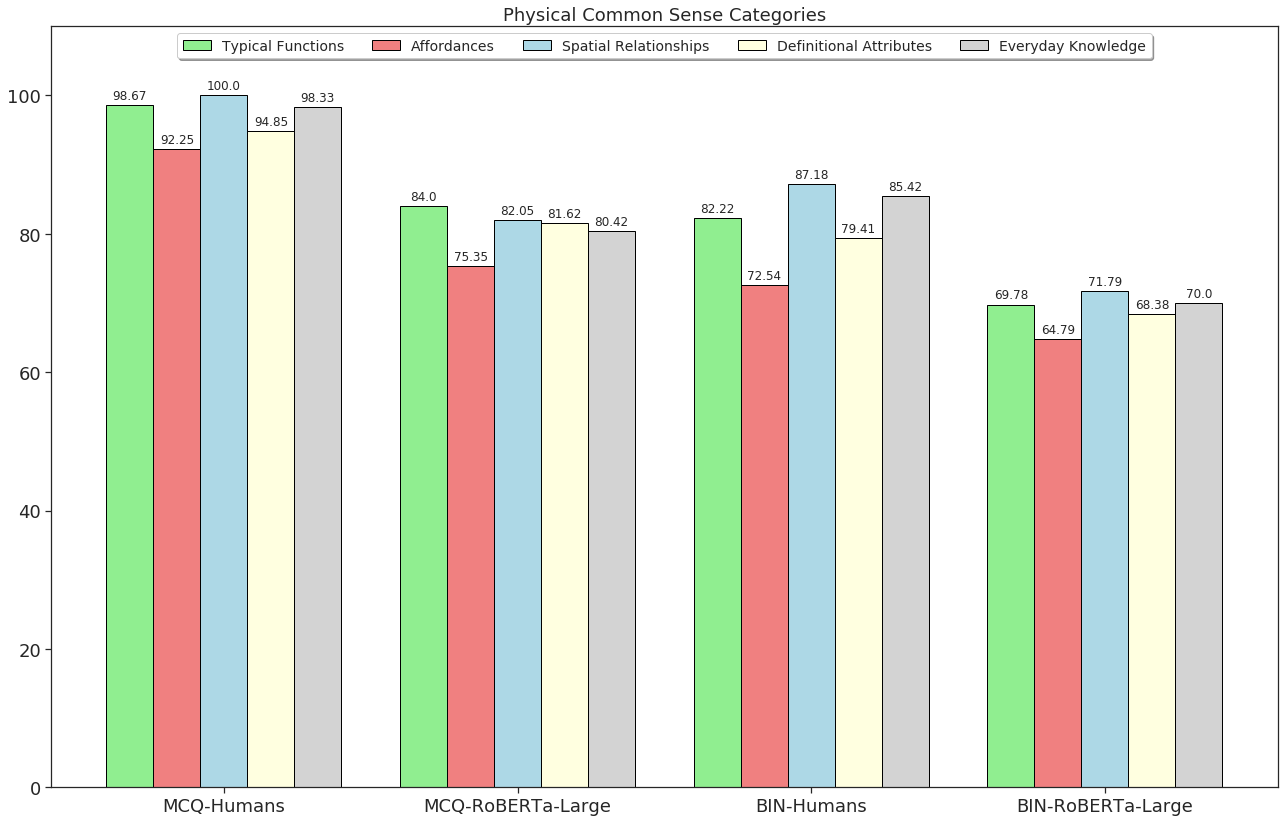

In [508]:
models_to_plot_and_str_mappings = {
    "MCQ-Humans": "MCQ-Humans",
    "large_roberta_bz4_accu2": "MCQ-RoBERTa-Large",
    "BIN-Humans": "BIN-Humans",
    "bz4_accu1_v2_contd": "BIN-RoBERTa-Large",
}
save_str = "imgs/grouped_bars_humans_models_cats.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="cat", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        bar_width=0.16, figsize=(22,14), save_str=save_str)

### Educational Levels

Version: 600 instances
--------------------------------------------------
Demographics: 5. education level
--------------------------------------------------
Most 10 year olds
MCQ-Humans: 98.4848%
large_roberta_bz4_accu2: 82.3232%
BIN-Humans: 89.8990%
bz4_accu1_v2_contd: 69.6970%
--------------------------------------------------
Not most 10 year olds
MCQ-Humans: 96.3636%
large_roberta_bz4_accu2: 81.4545%
BIN-Humans: 79.6364%
bz4_accu1_v2_contd: 65.0909%
--------------------------------------------------
Only domain experts
MCQ-Humans: 91.5663%
large_roberta_bz4_accu2: 79.5181%
BIN-Humans: 75.9036%
bz4_accu1_v2_contd: 69.8795%
--------------------------------------------------
Not sure
MCQ-Humans: 85.7143%
large_roberta_bz4_accu2: 71.4286%
BIN-Humans: 57.1429%
bz4_accu1_v2_contd: 53.5714%
--------------------------------------------------
['Most 10 year olds', 'Not most 10 year olds', 'Only domain experts', 'Not sure']


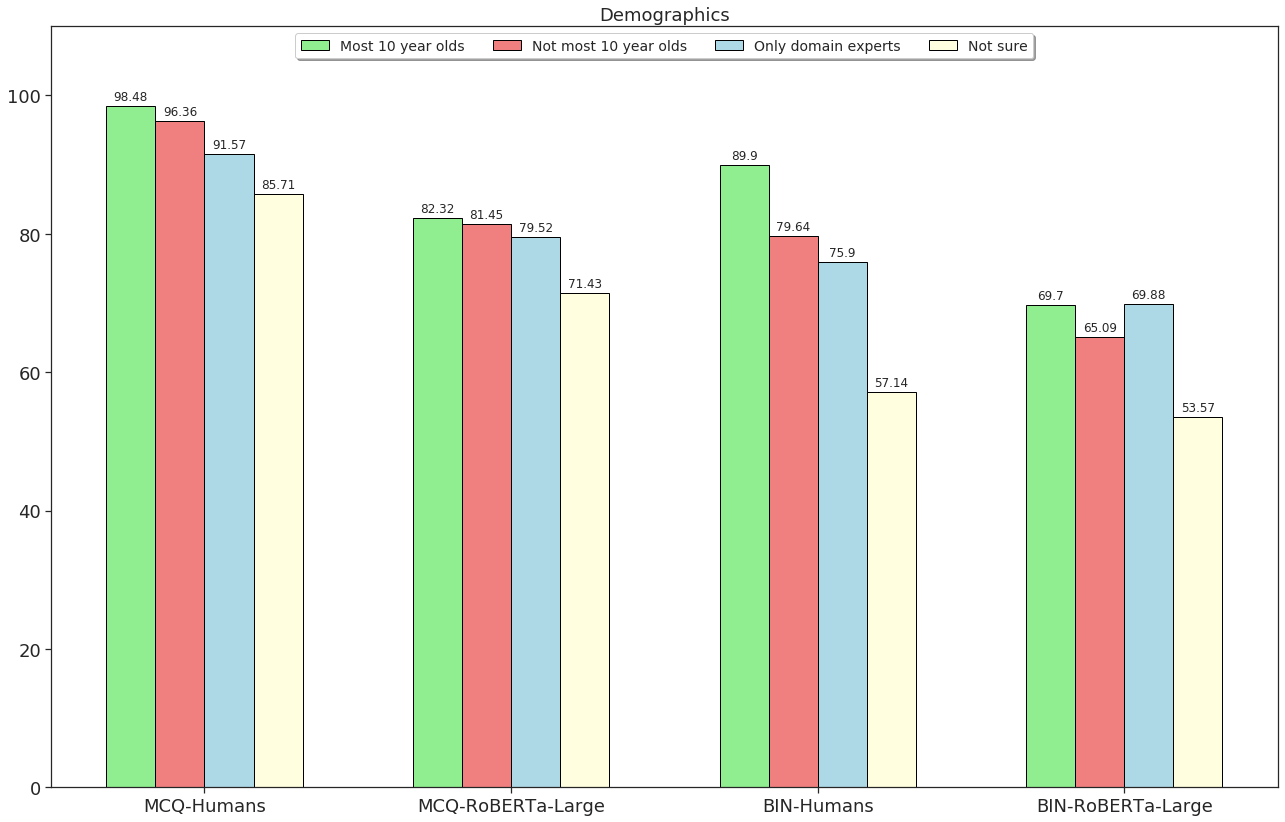

In [552]:
models_to_plot_and_str_mappings = {
    "MCQ-Humans": "MCQ-Humans",
    "large_roberta_bz4_accu2": "MCQ-RoBERTa-Large",
    "BIN-Humans": "BIN-Humans",
    "bz4_accu1_v2_contd": "BIN-RoBERTa-Large",
}
save_str = "imgs/grouped_bars_humans_models_edu.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="edu", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        bar_width=0.16, figsize=(22,14), save_str=save_str)

## Statistics

In [546]:
# functions
def overall_stats(qualt_dicts, mode="com", start_block=1, end_block=24, if_cs_kappa_mode="all"):
    assert mode in ["edu", "cat", "com", "clearness", "overall"]
    assert if_cs_kappa_mode in ["all", "no_ties"]
    
    mcq_qualt_dict, bin_qualt_dict = qualt_dicts
    qualt_ids = get_qualt_ids(start_block=start_block, end_block=end_block)
    
    # get number of annotators
    num_annotators_per_question = 0

    annots = mcq_qualt_dict[qualt_ids[0]]["annotations"]["1. choice"]
    num_annots = len(annots)
    num_annotators_per_question = max(num_annotators_per_question, num_annots)
    num_iaas = num_annotators_per_question * 2
    
    len_data = len(qualt_ids)
    
    mcq_choices = np.zeros((len_data, num_annotators_per_question))
    bin_choices = np.zeros((len_data, num_annotators_per_question))
    joint_choices = np.zeros((len_data, num_iaas))
    
    if if_cs_kappa_mode == "all":
        mcq_if_cs = np.zeros((len_data, num_annotators_per_question))
        bin_if_cs = np.zeros((len_data, num_annotators_per_question))
        joint_if_cs = np.zeros((len_data, num_iaas))
    else:
        mcq_if_cs = []
        bin_if_cs = []
        joint_if_cs = []
        
    mcq_mv_perf = []
    mcq_mv_if_cs = []
    bin_mv_perf = []
    bin_mv_if_cs = []
    
    for i in range(len(qualt_ids)):
        qualt_id = qualt_ids[i]
        
        mcq_annots = mcq_qualt_dict[qualt_id]["annotations"]
        bin_annots = bin_qualt_dict[qualt_id]["annotations"]
        mcq_gt = mcq_qualt_dict[qualt_id]["gt_label"]
        bin_gt = bin_qualt_dict[qualt_id]["gt_label"]
        
        mcq_human_choices = mcq_annots["1. choice"]
        bin_human_choices = bin_annots["1. choice"]
        mcq_human_choices_counter = Counter(mcq_human_choices)
        bin_human_choices_counter = Counter(bin_human_choices)
        mcq_human_choice, mcq_human_choice_cnt = mcq_human_choices_counter.most_common(1)[0]
        bin_human_choice, bin_human_choice_cnt = bin_human_choices_counter.most_common(1)[0]
        
        mcq_choices[i, :num_annotators_per_question] = mcq_human_choices
        bin_choices[i, :num_annotators_per_question] = bin_human_choices
        joint_choices[i, :num_annotators_per_question] = mcq_human_choices
        joint_choices[i, num_annotators_per_question:] = bin_human_choices
        
        assert mcq_human_choice_cnt > num_annotators_per_question // 2 and \
            bin_human_choice_cnt > num_annotators_per_question // 2
        
        mcq_human_if_css = mcq_annots["4. if common sense"]
        bin_human_if_css = bin_annots["4. if common sense"]
        mcq_human_if_css_counter = Counter(mcq_human_if_css)
        bin_human_if_css_counter = Counter(bin_human_if_css)
        mcq_human_if_cs, mcq_human_if_cs_cnt = mcq_human_if_css_counter.most_common(1)[0]
        bin_human_if_cs, bin_human_if_cs_cnt = bin_human_if_css_counter.most_common(1)[0]
        
        if if_cs_kappa_mode == "all":
            mcq_if_cs[i, :num_annotators_per_question] = mcq_human_if_css
            bin_if_cs[i, :num_annotators_per_question] = bin_human_if_css
            joint_if_cs[i, :num_annotators_per_question] = mcq_human_if_css
            joint_if_cs[i, num_annotators_per_question:] = bin_human_if_css
        elif if_cs_kappa_mode == "no_ties":
            joint_humans_if_css_counter = Counter(mcq_human_if_css+bin_human_if_css)
            joint_humans_if_cs, joint_humans_if_cs_cnt = joint_humans_if_css_counter.most_common(1)[0]
            if joint_humans_if_cs_cnt == num_annotators_per_question:
                pass # don't include
            else:
                mcq_if_cs.append(mcq_human_if_css)
                bin_if_cs.append(bin_human_if_css)
                joint_if_cs.append(mcq_human_if_css+bin_human_if_css)
         
        assert mcq_human_if_cs_cnt > num_annotators_per_question // 2 and \
            bin_human_if_cs_cnt > num_annotators_per_question // 2
            
        if mcq_human_choice == mcq_gt:
            mcq_mv_perf.append(1)
        else:
            mcq_mv_perf.append(0)
        if bin_human_choice == bin_gt:
            bin_mv_perf.append(1)
        else:
            bin_mv_perf.append(0)

        mcq_mv_if_cs.append(mcq_human_if_cs)
        bin_mv_if_cs.append(bin_human_if_cs)
        
    mcq_mv_perf = np.asarray(mcq_mv_perf)
    bin_mv_perf = np.asarray(bin_mv_perf)
    mcq_mv_if_cs = np.asarray(mcq_mv_if_cs)
    bin_mv_if_cs = np.asarray(bin_mv_if_cs)
    
    mcq_mv_perf_acc = np.mean(mcq_mv_perf)
    bin_mv_perf_acc = np.mean(bin_mv_perf)
    mcq_mv_if_cs_acc = np.mean(mcq_mv_if_cs)
    bin_mv_if_cs_acc = np.mean(bin_mv_if_cs)
    
    print ("MCQ-MV-Performance: {:.2f}%".format(mcq_mv_perf_acc*100))
    print ("BIN-MV-Performance: {:.2f}%".format(bin_mv_perf_acc*100))
    print ("MCQ-MV-If-CS: {:.2f}%".format(mcq_mv_if_cs_acc*100))
    print ("BIN-MV-If-CS: {:.2f}%".format(bin_mv_if_cs_acc*100))
        
    # Kappas and Fleiss
    len_data = len(mcq_choices)
    mcq_choices = np.transpose(mcq_choices).astype(np.int32)
    bin_choices = np.transpose(bin_choices).astype(np.int32)
    joint_choices = np.transpose(joint_choices).astype(np.int32)
    
    taskdata_mcq_choices = []
    taskdata_bin_choices = []
    taskdata_joint_choices = []
    for i in range(num_annotators_per_question):
        mcq_tmp = [[i, str(j), str(mcq_choices[i][j])] for j in range(len_data)]
        bin_tmp = [[i, str(j), str(bin_choices[i][j])] for j in range(len_data)]
        taskdata_mcq_choices += mcq_tmp
        taskdata_bin_choices += bin_tmp
    for i in range(num_iaas):
        joint_tmp = [[i, str(j), str(joint_choices[i][j])] for j in range(len_data)]
        taskdata_joint_choices += joint_tmp
        
    rating_mcq_choices = agreement.AnnotationTask(data=taskdata_mcq_choices)
    rating_bin_choices = agreement.AnnotationTask(data=taskdata_bin_choices)
    rating_joint_choices = agreement.AnnotationTask(data=taskdata_joint_choices)
    
    print ('-'*50)
    print ("Choices:")
    print ("MCQ Kappa:    {}".format(rating_mcq_choices.kappa()))
    print ("BIN Kappa:    {}".format(rating_bin_choices.kappa()))
    print ("Joint Kappa:  {}".format(rating_joint_choices.kappa()))
    print ("MCQ Fleiss:   {}".format(rating_mcq_choices.multi_kappa()))
    print ("BIN Fleiss:   {}".format(rating_bin_choices.multi_kappa()))
    print ("Joint Fleiss: {}".format(rating_joint_choices.multi_kappa()))
    
    if if_cs_kappa_mode == "no_ties":
        mcq_if_cs = np.asarray(mcq_if_cs)
        bin_if_cs = np.asarray(bin_if_cs)
        joint_if_cs = np.asarray(joint_if_cs)
    
    len_data = len(mcq_if_cs)
    mcq_if_cs = np.transpose(mcq_if_cs).astype(np.int32)
    bin_if_cs = np.transpose(bin_if_cs).astype(np.int32)
    joint_if_cs = np.transpose(joint_if_cs).astype(np.int32)
    
    taskdata_mcq_if_cs = []
    taskdata_bin_if_cs = []
    taskdata_joint_if_cs = []
    for i in range(num_annotators_per_question):
        mcq_tmp = [[i, str(j), str(mcq_if_cs[i][j])] for j in range(len_data)]
        bin_tmp = [[i, str(j), str(bin_if_cs[i][j])] for j in range(len_data)]
        taskdata_mcq_if_cs += mcq_tmp
        taskdata_bin_if_cs += bin_tmp
    for i in range(num_iaas):
        joint_tmp = [[i, str(j), str(joint_if_cs[i][j])] for j in range(len_data)]
        taskdata_joint_if_cs += joint_tmp
        
    rating_mcq_if_cs = agreement.AnnotationTask(data=taskdata_mcq_if_cs)
    rating_bin_if_cs = agreement.AnnotationTask(data=taskdata_bin_if_cs)
    rating_joint_if_cs = agreement.AnnotationTask(data=taskdata_joint_if_cs)
    
    print ('-'*50)
    print ("If CS (mode = {}):".format(if_cs_kappa_mode))
    print ("MCQ Kappa:    {}".format(rating_mcq_if_cs.kappa()))
    print ("BIN Kappa:    {}".format(rating_bin_if_cs.kappa()))
    print ("Joint Kappa:  {}".format(rating_joint_if_cs.kappa()))
    print ("MCQ Fleiss:   {}".format(rating_mcq_if_cs.multi_kappa()))
    print ("BIN Fleiss:   {}".format(rating_bin_if_cs.multi_kappa()))
    print ("Joint Fleiss: {}".format(rating_joint_if_cs.multi_kappa()))
    print ('-'*50)
    
    return None

In [547]:
overall_stats(qualt_dicts, mode="cat", start_block=1, end_block=24, if_cs_kappa_mode="all")

Version: 720 instances
--------------------------------------------------
MCQ-MV-Performance: 93.75%
BIN-MV-Performance: 77.22%
MCQ-MV-If-CS: 72.22%
BIN-MV-If-CS: 69.03%
--------------------------------------------------
Choices:
MCQ Kappa:    0.7456801512839593
BIN Kappa:    0.41180413803238264
Joint Kappa:  0.24083019495870367
MCQ Fleiss:   0.7456709398624188
BIN Fleiss:   0.41179243059810533
Joint Fleiss: 0.23906624553750563
--------------------------------------------------
If CS (mode = all):
MCQ Kappa:    0.2463649837733972
BIN Kappa:    0.3421300761033363
Joint Kappa:  0.28042239871122193
MCQ Fleiss:   0.24692852590589048
BIN Fleiss:   0.3425793907971485
Joint Fleiss: 0.2817667132641987
--------------------------------------------------


In [548]:
overall_stats(qualt_dicts, mode="cat", start_block=1, end_block=24, if_cs_kappa_mode="no_ties")

Version: 720 instances
--------------------------------------------------
MCQ-MV-Performance: 93.75%
BIN-MV-Performance: 77.22%
MCQ-MV-If-CS: 72.22%
BIN-MV-If-CS: 69.03%
--------------------------------------------------
Choices:
MCQ Kappa:    0.7456801512839593
BIN Kappa:    0.41180413803238264
Joint Kappa:  0.24083019495870367
MCQ Fleiss:   0.7456709398624188
BIN Fleiss:   0.41179243059810533
Joint Fleiss: 0.23906624553750563
--------------------------------------------------
If CS (mode = no_ties):
MCQ Kappa:    0.2864650898597096
BIN Kappa:    0.4077023146142955
Joint Kappa:  0.3444619124280066
MCQ Fleiss:   0.2870645079257437
BIN Fleiss:   0.40787626357169604
Joint Fleiss: 0.3460847277511229
--------------------------------------------------


In [549]:
overall_stats(qualt_dicts, mode="cat", start_block=1, end_block=20, if_cs_kappa_mode="all")

Version: 600 instances
--------------------------------------------------
MCQ-MV-Performance: 95.00%
BIN-MV-Performance: 80.00%
MCQ-MV-If-CS: 73.00%
BIN-MV-If-CS: 70.50%
--------------------------------------------------
Choices:
MCQ Kappa:    0.7729111151280437
BIN Kappa:    0.43283968166754
Joint Kappa:  0.2543260726883649
MCQ Fleiss:   0.7729035322406481
BIN Fleiss:   0.4327549955376726
Joint Fleiss: 0.2524486642133701
--------------------------------------------------
If CS (mode = all):
MCQ Kappa:    0.24744482238902385
BIN Kappa:    0.3342267099114477
Joint Kappa:  0.2810728866865493
MCQ Fleiss:   0.248032486434039
BIN Fleiss:   0.3348959611430314
Joint Fleiss: 0.28244730935161555
--------------------------------------------------


In [550]:
overall_stats(qualt_dicts, mode="cat", start_block=1, end_block=20, if_cs_kappa_mode="no_ties")

Version: 600 instances
--------------------------------------------------
MCQ-MV-Performance: 95.00%
BIN-MV-Performance: 80.00%
MCQ-MV-If-CS: 73.00%
BIN-MV-If-CS: 70.50%
--------------------------------------------------
Choices:
MCQ Kappa:    0.7729111151280437
BIN Kappa:    0.43283968166754
Joint Kappa:  0.2543260726883649
MCQ Fleiss:   0.7729035322406481
BIN Fleiss:   0.4327549955376726
Joint Fleiss: 0.2524486642133701
--------------------------------------------------
If CS (mode = no_ties):
MCQ Kappa:    0.2929813091407725
BIN Kappa:    0.40033022786399863
Joint Kappa:  0.34166818554332207
MCQ Fleiss:   0.29375046444229747
BIN Fleiss:   0.40059557086951053
Joint Fleiss: 0.343084964436553
--------------------------------------------------


### Other Stats